
Training Linear Regression model...
Model Metrics:
MAE: 0.0154
RMSE: 0.0218
SMAPE: 12.94%
Linear Regression predictions: [[0.81987953 0.78637123 0.8003273  0.77310181 0.77670288 0.76545334
  0.75593948]
 [0.7912693  0.80620003 0.77634048 0.78279114 0.77246857 0.77176285
  0.77005386]
 [0.79629326 0.76877403 0.77819443 0.76633453 0.7599411  0.75307083
  0.75236893]
 [0.78079796 0.79446983 0.77956009 0.77287292 0.76202393 0.76254654
  0.77022171]
 [0.8038044  0.79325676 0.78680038 0.77503967 0.78079987 0.8021431
  0.78381729]]
Corresponding actual prices: [[0.82785465 0.77694432 0.80334823 0.786923   0.80547753 0.80172372
  0.80161079]
 [0.77694432 0.80334823 0.786923   0.80547753 0.80172372 0.80161079
  0.77929267]
 [0.80334823 0.786923   0.80547753 0.80172372 0.80161079 0.77929267
  0.78904706]
 [0.786923   0.80547753 0.80172372 0.80161079 0.77929267 0.78904706
  0.82020948]
 [0.80547753 0.80172372 0.80161079 0.77929267 0.78904706 0.82020948
  0.82020948]]


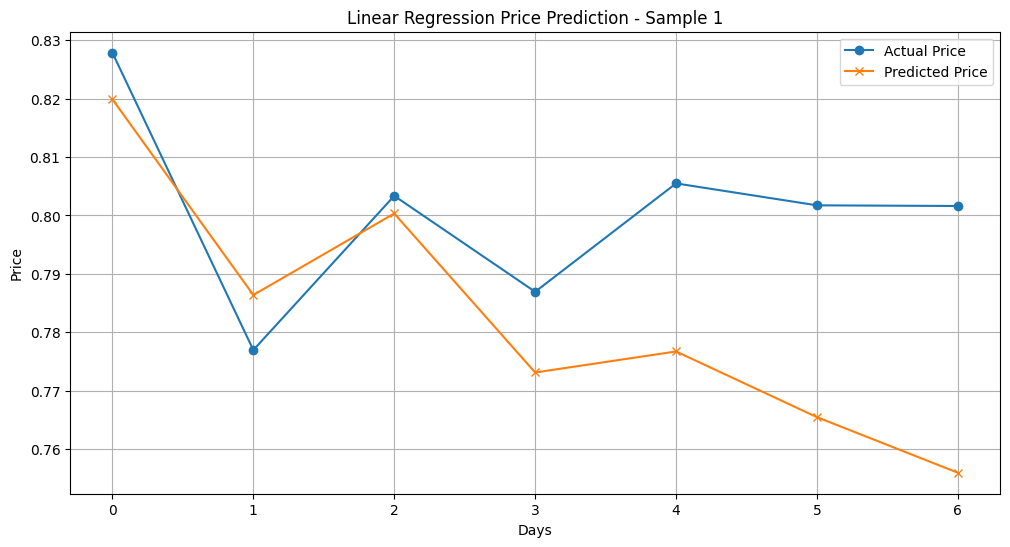

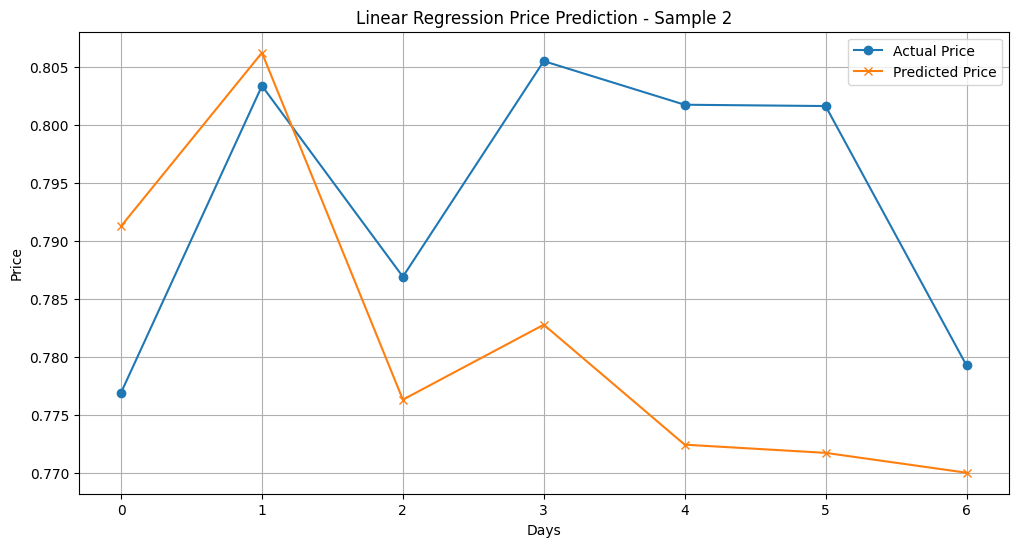

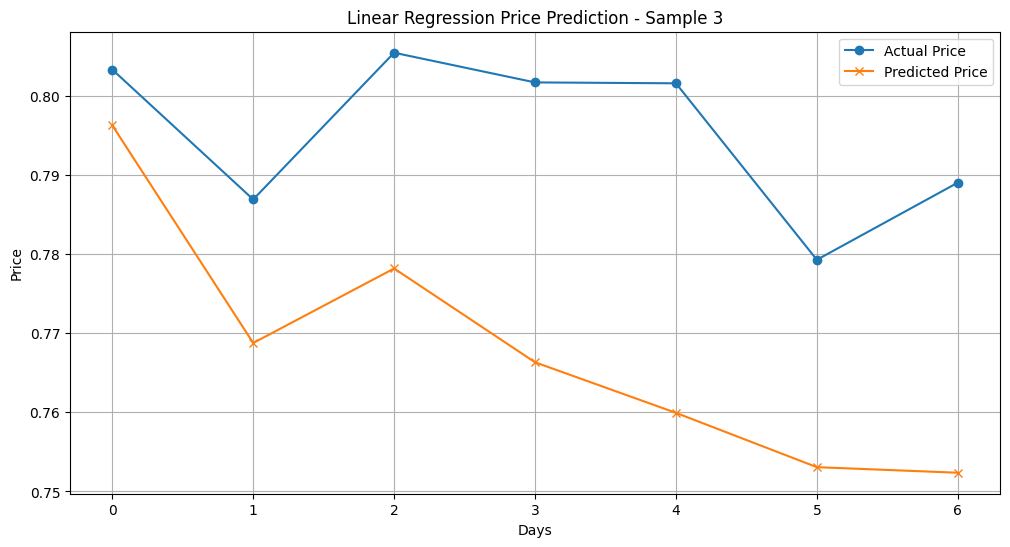

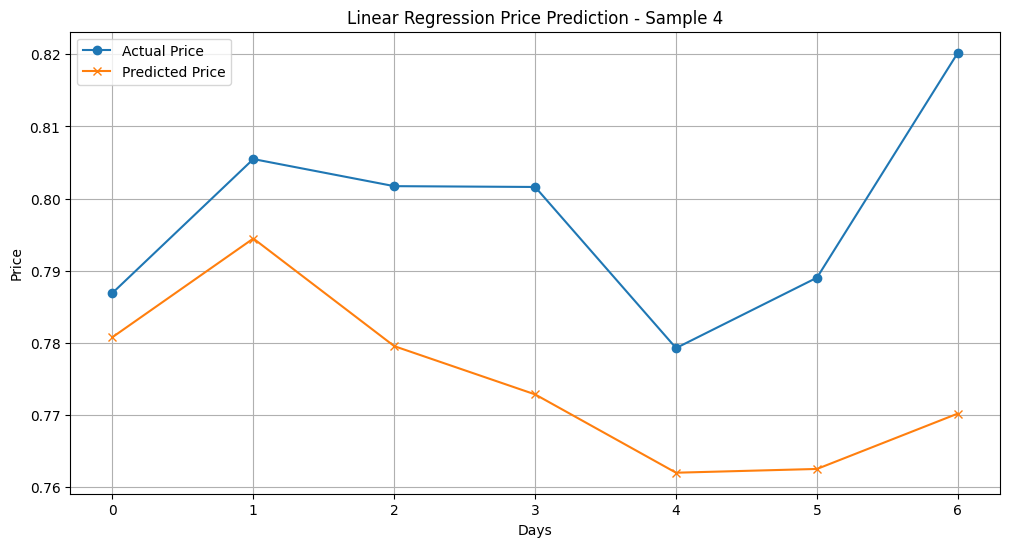

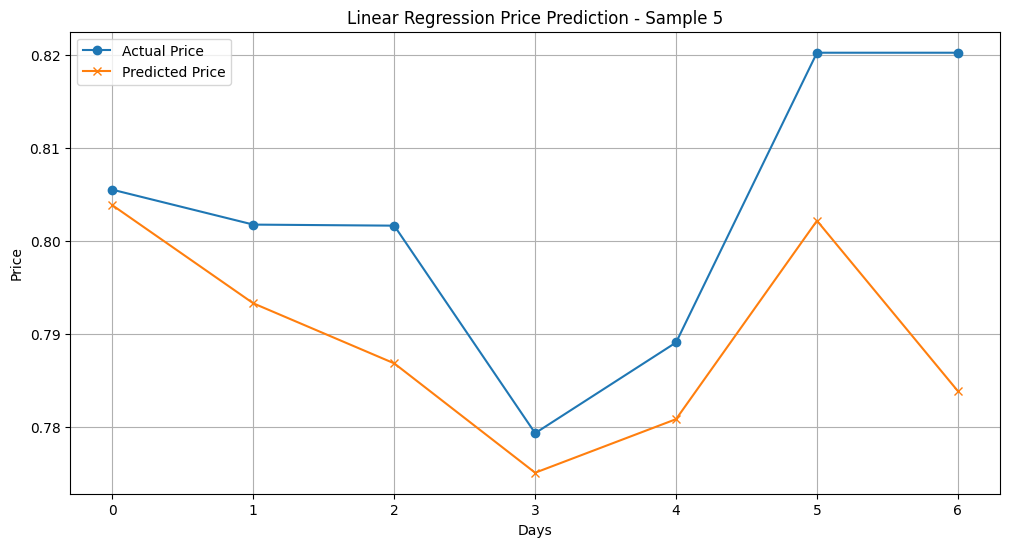

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def prepare_data(file_path, sequence_length=30, prediction_window=7, step=1):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df.sort_values('Date')

    features = ['Open', 'High', 'Low', 'Close_lag_7', 'Close_lag_14',
                'Close_rolling_7', 'Close_rolling_14', 'MA(7)', 'MA(25)', 'MA(99)',
                'RSI', 'Vol(USDT)', 'Ensemble_Sentiment', 'Sentiment_7day_MA',
                'Sentiment_Change', 'Sentiment_Volatility']
    target = 'Close'

    # Add more technical indicators
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    features += ['EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram']

    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    df[features] = scaler_features.fit_transform(df[features])
    df[target] = scaler_target.fit_transform(df[[target]])

    X, y = [], []
    for i in range(0, len(df) - sequence_length - prediction_window + 1, step):
        X.append(df[features].iloc[i:i+sequence_length].values.flatten())
        y.append(df[target].iloc[i+sequence_length:i+sequence_length+prediction_window].values)

    return np.array(X), np.array(y), scaler_features, scaler_target

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))
    return mae, rmse, smape

def train_and_evaluate(X, y, model):
    model.fit(X, y)
    predictions = model.predict(X)

    original_predictions = scaler_target.inverse_transform(predictions)
    original_y = scaler_target.inverse_transform(y)

    mae, rmse, smape = evaluate_model(original_y, original_predictions)

    print("Model Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"SMAPE: {smape:.2f}%")

    return model, (mae, rmse, smape)

def plot_predictions(actual, predicted, title='Cryptocurrency Price Prediction'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Price', marker='o')
    plt.plot(predicted, label='Predicted Price', marker='x')
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
file_path = '/kaggle/input/dataset/processed_dataset.csv'
sequence_length = 30
prediction_window = 7
step = 1

X, y, scaler_features, scaler_target = prepare_data(file_path, sequence_length, prediction_window, step)


# Linear Regression
print("\nTraining Linear Regression model...")
lr_model = LinearRegression()
lr_model, lr_metrics = train_and_evaluate(X, y, lr_model)

# Make predictions using both models
sample_X = X[-5:]  # Get the last 5 samples


lr_predictions = lr_model.predict(sample_X)

lr_original_predictions = scaler_target.inverse_transform(lr_predictions)
original_y = scaler_target.inverse_transform(y[-5:])

print("Linear Regression predictions:", lr_original_predictions)
print("Corresponding actual prices:", original_y)

# Plot predictions
for i in range(len(original_y)):
    plot_predictions(original_y[i], lr_original_predictions[i], f'Linear Regression Price Prediction - Sample {i+1}')
